In [1]:
# pip install git+https://github.com/xunzheng/notears.git

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from notears.linear import notears_linear
import networkx as nx
import matplotlib.pyplot as plt

# 데이터 전처리
df = pd.read_csv("training_data.csv")
# X = df.values
# label 제거 필요
X = df.drop(columns=["Unnamed: 0", "label"]).values
X = StandardScaler().fit_transform(X)

# NOTEARS 실행
W = notears_linear(X, lambda1=0.1, loss_type='l2')  # lambda1으로 sparsity 조절

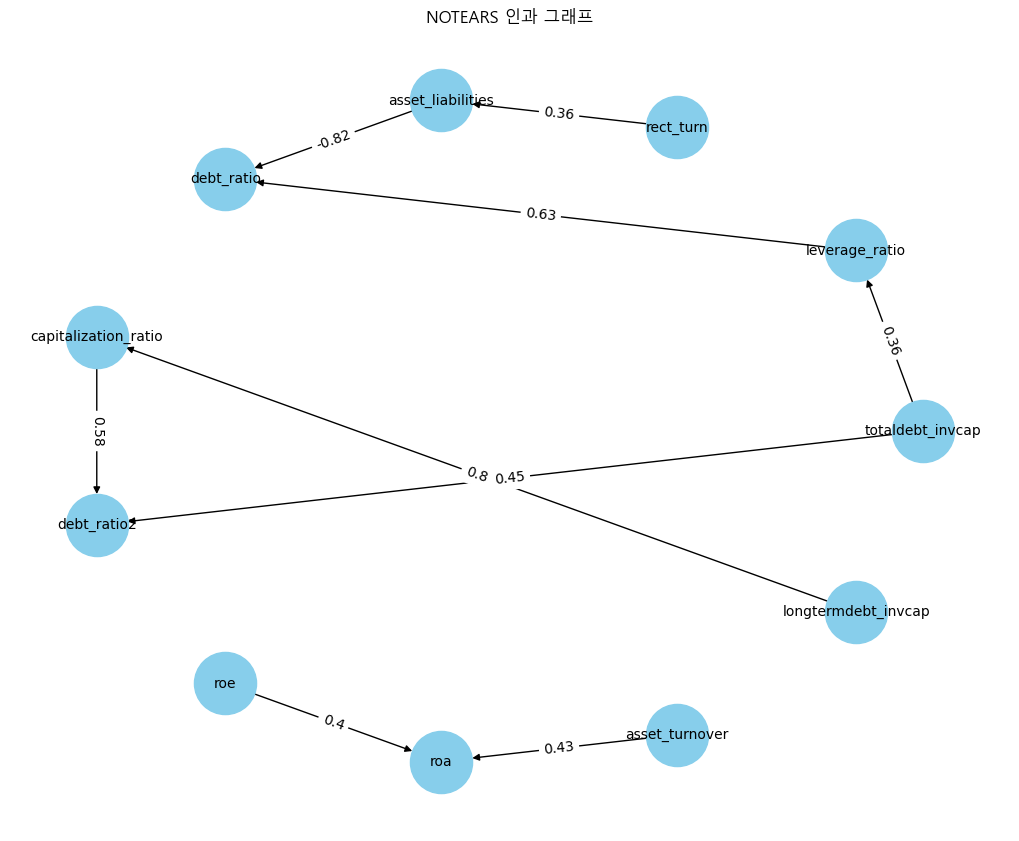

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 기호 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False


# 인과 그래프 시각화
cols = df.columns[1:-1]  # label 제외한 열 이름
G = nx.DiGraph()

for i in range(len(cols)):
    for j in range(len(cols)):
        if abs(W[i, j]) > 0.01:  # threshold 적용(0 제외)
            G.add_edge(cols[j], cols[i], weight=round(W[i, j], 2))

plt.figure(figsize=(10, 8))
# pos = nx.spring_layout(G)
# pos = nx.shell_layout(G)
# pos = nx.kamada_kawai_layout(G)
pos = nx.circular_layout(G)

nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'))
plt.title("NOTEARS 인과 그래프")
plt.show()


In [4]:
# [Cell 1] Imports & Global Config (NOTEARS + XGBoost)
import os
import warnings
import numpy as np
import pandas as pd
from pathlib import Path

# ML / CV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, brier_score_loss

# XGBoost (LightGBM → XGBoost로 변경)
from xgboost import XGBClassifier

# Causal & Graph
from notears.linear import notears_linear
import networkx as nx

# Viz
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Node/Feature/NOTEARS config
N_NODES        = 8           # 25 → 8
NOTEARS_LAMBDA = 0.1         # sparsity
NOTEARS_LOSS   = 'l2'        # 연속형 특성에 적합
W_EPS          = 1e-12       # OLS 가중치 임계 (간선 필터)
TOP_K_EDGES    = 25          # 파생피처 상위 K (원하면 조정)


In [5]:
# [Cell 2] Load data & pick 8 nodes (rect_turn 우선 포함)
df = pd.read_csv("training_data.csv")

# 후보 피처(순서 보존), 불필요 컬럼 제외
all_feats = [c for c in df.columns if c not in ("label", "Unnamed: 0")]
if len(all_feats) < N_NODES:
    raise ValueError(f"피처 {len(all_feats)}개로는 N_NODES={N_NODES} 선택이 불가합니다.")

# 'rect_turn'를 우선 포함하고 나머지로 채움
ordered = []
if "rect_turn" in all_feats:
    ordered.append("rect_turn")
remaining = [c for c in all_feats if c not in ordered]
cols = (ordered + remaining)[:N_NODES]

X_base = df[cols].copy()
y = df["label"].astype(int) if "label" in df.columns else None

# 표준화 Z (NOTEARS/OLS는 Z 공간 사용)
Z = StandardScaler().fit_transform(X_base.values.astype(float))

print(f"[INFO] 선택된 노드({len(cols)}개): {cols}")


[INFO] 선택된 노드(8개): ['rect_turn', 'leverage_ratio', 'asset_liabilities', 'roe', 'asset_turnover', 'debt_ratio', 'debt_ratio2', 'roa']


In [6]:
# [Cell 3] NOTEARS 실행 → A(child,parent)=1 (parent→child)
W_note = notears_linear(Z, lambda1=NOTEARS_LAMBDA, loss_type=NOTEARS_LOSS)

# 간선 존재 여부로 A 구성
A = (np.abs(W_note) > 0).astype(float)
np.fill_diagonal(A, 0.0)

# DAG 검사
G_tmp = nx.DiGraph()
p = len(cols)
for child in range(p):
    for parent in range(p):
        if child != parent and A[child, parent] == 1.0:
            G_tmp.add_edge(parent, child)
if not nx.is_directed_acyclic_graph(G_tmp):
    raise ValueError("NOTEARS 결과에서 DAG가 아닙니다. (사이클 감지)")

print("[INFO] NOTEARS 완료. 간선 수:", int(A.sum()))


[INFO] NOTEARS 완료. 간선 수: 5


In [7]:
# [Cell 4] OLS 가중치 재적합 (Z 공간, 절편 없음) → W(child,parent)
W = np.zeros_like(A, dtype=float)
for child in range(p):
    parents = np.where(A[child, :] == 1.0)[0]
    if parents.size == 0:
        continue
    y_child = Z[:, child]
    X_par   = Z[:, parents]
    coef, *_ = np.linalg.lstsq(X_par, y_child, rcond=None)
    W[child, parents] = coef.astype(float)

print("[INFO] OLS 재적합 완료. |W|>eps 간선 수:", int(((A==1.0) & (np.abs(W) > W_EPS)).sum()))


[INFO] OLS 재적합 완료. |W|>eps 간선 수: 5


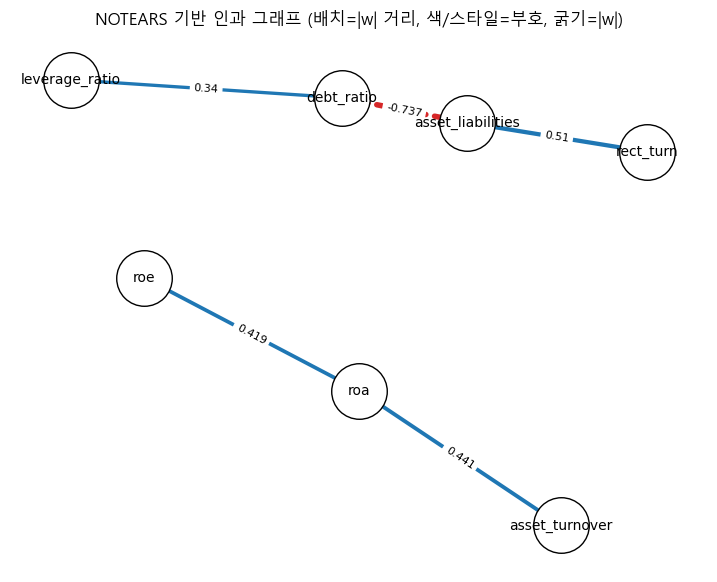

In [8]:
# [Cell 5] 시각화 (부호/굵기 반영, |w|-거리 레이아웃)
USE_QUANTILE    = False
W_THRESHOLD     = 0.01
W_ABS_QUANTILE  = 0.90
TOP_K_EDGES_VIS = None  # 시각화 전용 상위K

def get_threshold(W, fixed=W_THRESHOLD, use_q=USE_QUANTILE, q=W_ABS_QUANTILE):
    if not use_q:
        return fixed
    aw = np.abs(W).ravel()
    aw = aw[aw > 0]
    return float(np.quantile(aw, q)) if aw.size else fixed

thr = get_threshold(W)

edges_all = []
for i in range(p):      # child
    for j in range(p):  # parent
        if i==j: 
            continue
        w = float(W[i, j])
        if A[i, j]==1.0 and abs(w) > thr:
            edges_all.append((cols[j], cols[i], w))

if TOP_K_EDGES_VIS is not None and TOP_K_EDGES_VIS>0 and len(edges_all)>TOP_K_EDGES_VIS:
    edges_all = sorted(edges_all, key=lambda t: abs(t[2]), reverse=True)[:TOP_K_EDGES_VIS]

G = nx.DiGraph()
for u, v, w in edges_all:
    G.add_edge(u, v, weight=round(w, 3))

eps = 1e-6
H = nx.Graph()
for u, v, d in G.edges(data=True):
    w = d.get("weight", 0.0)
    H.add_edge(u, v, weight=1.0/(abs(w)+eps))
pos = nx.kamada_kawai_layout(H, weight='weight')

max_abs = max((abs(d["weight"]) for _,_,d in G.edges(data=True)), default=1.0)
pos_edges = [(u,v) for u,v,d in G.edges(data=True) if d["weight"]>=0]
neg_edges = [(u,v) for u,v,d in G.edges(data=True) if d["weight"]<0]
pos_widths = [1.0 + 3.0*abs(G[u][v]["weight"])/max_abs for u,v in pos_edges]
neg_widths = [1.0 + 3.0*abs(G[u][v]["weight"])/max_abs for u,v in neg_edges]

plt.figure(figsize=(9,7))
nx.draw_networkx_nodes(G, pos, node_size=1600, node_color="white", edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, edgelist=pos_edges, edge_color="tab:blue", width=pos_widths, arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=neg_edges, edge_color="tab:red",  width=neg_widths, style="dashed", arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G,'weight'), font_size=8)
plt.title("NOTEARS 기반 인과 그래프 (배치=|w| 거리, 색/스타일=부호, 굵기=|w|)")
plt.axis("off")
plt.show()


In [9]:
# [Cell 6] 회귀식/잔차 저장 (scenario='rect_turn')
OUT_DIR   = Path("scm_outputs")
RESID_DIR = OUT_DIR / "residuals"
OUT_DIR.mkdir(parents=True, exist_ok=True)
RESID_DIR.mkdir(parents=True, exist_ok=True)

scenario_var = "rect_turn"
if scenario_var not in cols:
    raise ValueError(f"'{scenario_var}'가 cols에 없습니다. 현재 cols={cols}")
scenario_idx = cols.index(scenario_var)

children_idx = np.where(A[:, scenario_idx] == 1.0)[0]
children = [cols[i] for i in children_idx]
print(f"[정보] '{scenario_var}'의 직접 자식 수: {len(children)} -> {children}")

records = []
equations_lines = []
n = Z.shape[0]

for child in children_idx:
    parents = np.where(A[child, :] == 1.0)[0]
    if parents.size == 0:
        continue
    y_child = Z[:, child]
    X_par   = Z[:, parents]
    coef, *_ = np.linalg.lstsq(X_par, y_child, rcond=None)
    y_hat = X_par @ coef
    resid = y_child - y_hat

    ss_res = float(np.sum(resid**2))
    ss_tot = float(np.sum(y_child**2) + 1e-12)
    r2 = 1.0 - ss_res / ss_tot

    child_name = cols[child]
    np.save(RESID_DIR / f"{child_name}.npy", resid)

    for p_idx, c in zip(parents, coef):
        records.append({
            "child": child_name,
            "parent": cols[p_idx],
            "coef": float(c),
            "r2": float(r2),
            "n_parents": int(parents.size)
        })
    parts = [f"{float(c):+.4f}·{cols[p_idx]}" for p_idx, c in zip(parents, coef)]
    equations_lines.append(f"{child_name} = " + " ".join(parts) + f" + ε_{child_name}")

if records:
    df_coef = pd.DataFrame(records).sort_values(["child","parent"]).reset_index(drop=True)
    out_csv = OUT_DIR / f"coeffs_{scenario_var}.csv"
    df_coef.to_csv(out_csv, index=False, encoding="utf-8-sig")
    with open(OUT_DIR / f"equations_{scenario_var}.txt","w",encoding="utf-8") as f:
        f.write("# 회귀식(표준화, 절편 없음)\n")
        f.write(f"# scenario_var = {scenario_var}\n\n")
        for line in equations_lines: f.write(line+"\n")
    print(f"[저장] coeffs: {out_csv}, equations: {OUT_DIR / f'equations_{scenario_var}.txt'}")
else:
    print("[알림] 저장할 레코드가 없습니다.")


[정보] 'rect_turn'의 직접 자식 수: 1 -> ['asset_liabilities']
[저장] coeffs: scm_outputs\coeffs_rect_turn.csv, equations: scm_outputs\equations_rect_turn.txt


In [10]:
# [Cell 7] do-Intervention (rect_turn) 시뮬레이터
def simulate_do_rect_turn(
    A: np.ndarray,
    W: np.ndarray,
    Z: np.ndarray,
    cols: list,
    X_base: pd.DataFrame,
    delta_raw: float = 1.0,
    n_iter: int = 100,
    residual_dir: Path = Path("scm_outputs") / "residuals",
    use_bootstrap: bool = True,
    random_state: int = 42,
    save_each_iter: bool = False,
    save_dir: Path = Path("scm_outputs") / "synthetic"
):
    import numpy as np, pandas as pd, networkx as nx
    rng = np.random.default_rng(random_state)
    if "rect_turn" not in cols:
        raise ValueError("'rect_turn'가 cols에 없습니다.")
    idx_scn = cols.index("rect_turn")

    n, p = Z.shape
    mean_vec = X_base.values.astype(float).mean(axis=0)
    std_vec  = X_base.values.astype(float).std(axis=0, ddof=0)
    if np.any(std_vec == 0):
        raise ValueError("표준편차 0인 변수가 있습니다.")

    G = nx.DiGraph()
    for child in range(p):
        parents = np.where(A[child, :]==1.0)[0]
        for par in parents: G.add_edge(par, child)
    if not nx.is_directed_acyclic_graph(G):
        raise ValueError("그래프에 사이클이 있습니다.")

    descendants = nx.descendants(G, idx_scn)
    sub_nodes   = [idx_scn] + sorted(descendants)
    topo_order  = [u for u in nx.topological_sort(G) if u in sub_nodes]

    residuals = {}
    for child in sub_nodes:
        child_name = cols[child]
        npy_path = residual_dir / f"{child_name}.npy"
        if npy_path.exists():
            residuals[child] = np.load(npy_path)
        else:
            residuals[child] = rng.normal(0.0, 0.5, size=n)

    if save_each_iter:
        save_dir.mkdir(parents=True, exist_ok=True)

    results = []
    z_shift = delta_raw / std_vec[idx_scn]

    for it in range(n_iter):
        Z_new = Z.copy()
        Z_new[:, idx_scn] = Z_new[:, idx_scn] + z_shift
        for node in topo_order:
            if node == idx_scn: continue
            parents = np.where(A[node,:]==1.0)[0]
            if parents.size==0: continue
            lin = Z_new[:, parents] @ W[node, parents]
            if use_bootstrap:
                eps = rng.choice(residuals[node], size=n, replace=True)
            else:
                std_eps = np.std(residuals[node]) if residuals[node].size>1 else 0.5
                eps = rng.normal(0.0, std_eps, size=n)
            Z_new[:, node] = lin + eps

        X_new = (Z_new * std_vec.reshape(1,-1)) + mean_vec.reshape(1,-1)
        X_new_df = pd.DataFrame(X_new, columns=cols)

        if save_each_iter:
            save_dir.mkdir(parents=True, exist_ok=True)
            X_new_df.to_csv(save_dir/f"synthetic_rect_turn_it{it+1:04d}.csv", index=False, encoding="utf-8-sig")
        results.append((Z_new, X_new_df))
    return {
        "descendants_only":[cols[i] for i in descendants],
        "topo_order_names":[cols[i] for i in topo_order],
        "results": results
    }


In [11]:
# [Cell 8] 개입 실행 & CSV 저장 래퍼
def run_and_save_rect_turn_csv(
    A, W, Z, cols, X_base, df, y,
    delta_raw=1.0, n_iter=100,
    residual_dir=Path("scm_outputs")/"residuals",
    out_dir=Path("scm_outputs")/"synthetic",
    random_state=42,
    use_bootstrap=True
):
    out_dir.mkdir(parents=True, exist_ok=True)
    sim = simulate_do_rect_turn(
        A=A, W=W, Z=Z, cols=cols, X_base=X_base,
        delta_raw=delta_raw, n_iter=n_iter,
        residual_dir=residual_dir, use_bootstrap=use_bootstrap,
        random_state=random_state, save_each_iter=False
    )
    combined = []
    row_ids = df["Unnamed: 0"].values if "Unnamed: 0" in df.columns else df.index.values
    row_id_name = "row_id"

    for it, (_, X_new_df) in enumerate(sim["results"], start=1):
        X_new_df.insert(0, row_id_name, row_ids)
        if y is not None:
            X_new_df["label"] = y.values
        X_new_df["_iter"] = it
        X_new_df["_intervention"] = "rect_turn"
        X_new_df["_delta_raw"] = float(delta_raw)
        per_path = out_dir / f"synthetic_rect_turn_it{it:04d}.csv"
        X_new_df.to_csv(per_path, index=False, encoding="utf-8-sig")
        combined.append(X_new_df)

    df_all = pd.concat(combined, axis=0, ignore_index=True)
    all_path = out_dir / "synthetic_rect_turn_all.csv"
    df_all.to_csv(all_path, index=False, encoding="utf-8-sig")

    print(f"[저장] 반복별 CSV: {out_dir/'synthetic_rect_turn_it0001.csv'} ... it{n_iter:04d}.csv")
    print(f"[저장] 통합 CSV: {all_path} (rows={len(df_all)})")
    return {"descendants": sim["descendants_only"], "topo_order": sim["topo_order_names"], "all_path": all_path}


In [12]:
# [Cell 9] 파생피처 생성기 (NOTEARS A + OLS W)
from typing import Optional, List, Tuple

def _remove_constant_columns(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.shape[1]==0:
        return df
    var = df.var(axis=0, ddof=0)
    keep = var[~np.isclose(var.values, 0.0)].index
    return df[keep]

def _pick_top_k_edges_ols(
    W: np.ndarray, A: np.ndarray, cols: List[str],
    top_k: Optional[int], eps: float
) -> List[Tuple[int, int, float]]:
    p = W.shape[0]
    flat: List[Tuple[int, int, float]] = []
    for i in range(p):          # child
        for j in range(p):      # parent
            if i==j: continue
            if A[i, j] != 1.0:  continue
            w = float(W[i, j])
            if abs(w) > eps:
                flat.append((i, j, w))
    flat.sort(key=lambda t: (abs(t[2]), t[2]), reverse=True)
    return flat if (top_k is None) else flat[:min(top_k, len(flat))]

def build_feature_df_from_graph_ols(
    X_base: pd.DataFrame,
    cols: List[str],
    W: np.ndarray,
    A: np.ndarray,
    feature_type: str = "mul",
    top_k: Optional[int] = 25,
    eps: float = 1e-12,
) -> pd.DataFrame:
    """
    feature_type:
      - "mul"  : parent * child
      - "mulw" : (W_ij) * (parent * child)
    """
    edges = _pick_top_k_edges_ols(W, A, cols, top_k=top_k, eps=eps)
    if len(edges)==0:
        return pd.DataFrame(index=X_base.index)
    feats = {}
    for child_idx, parent_idx, w_ij in edges:
        parent_name = cols[parent_idx]
        child_name  = cols[child_idx]
        if feature_type == "mul":
            feats[f"{parent_name}_mul_{child_name}"]  = X_base[parent_name] * X_base[child_name]
        elif feature_type == "mulw":
            feats[f"{parent_name}_mulw_{child_name}"] = float(w_ij) * (X_base[parent_name] * X_base[child_name])
    X_feat = pd.DataFrame(feats, index=X_base.index)
    return _remove_constant_columns(X_feat)


In [13]:
# [Cell 10] CV 유틸 (XGBoost 버전)
from datetime import datetime

def expected_calibration_error(y_true: np.ndarray, y_prob: np.ndarray, n_bins: int = 10) -> float:
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    if len(np.unique(y_true)) < 2:
        return np.nan
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece, total = 0.0, len(y_true)
    for b in range(n_bins):
        left, right = bins[b], bins[b+1]
        mask = (y_prob >= left) & (y_prob < right) if b < n_bins-1 else (y_prob >= left) & (y_prob <= right)
        if mask.sum() == 0:
            continue
        acc  = y_true[mask].mean()
        conf = y_prob[mask].mean()
        ece += (mask.sum()/total) * abs(acc - conf)
    return float(ece)

def best_threshold_by_f1(y_true: np.ndarray, y_prob: np.ndarray) -> float:
    ts = np.linspace(0.05, 0.95, 19)
    scores = [(t, f1_score(y_true, (y_prob >= t).astype(int), zero_division=0)) for t in ts]
    return float(max(scores, key=lambda x: x[1])[0])

def make_model_xgb():
    # CPU 친화 파라미터 (필요시 튜닝)
    return XGBClassifier(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.0, reg_lambda=0.0,
        random_state=RANDOM_STATE, objective="binary:logistic",
        tree_method="hist", eval_metric="logloss", n_jobs=-1
    )

def run_cv_xgb(X: pd.DataFrame, y: pd.Series, n_splits=10, random_state=42, tag: str = "") -> dict:
    if X is None or X.shape[1]==0:
        return {m: np.nan for m in ["f1","AUPRC","AUROC","Brier","ECE"]}
    X_np, y_np = X.values, y.values.astype(int)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    f1s, auprcs, aurocs, briers, eces = [], [], [], [], []
    for fold, (tr_idx, te_idx) in enumerate(skf.split(X_np, y_np), start=1):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
        X_tr_sub, X_val, y_tr_sub, y_val = train_test_split(
            X_tr, y_tr, test_size=0.2, random_state=random_state, stratify=y_tr
        )
        clf = make_model_xgb()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            clf.fit(X_tr_sub, y_tr_sub)
        y_val_proba = clf.predict_proba(X_val)[:, 1]
        t = best_threshold_by_f1(y_val, y_val_proba)
        y_proba = clf.predict_proba(X_te)[:, 1]
        y_pred  = (y_proba >= t).astype(int)
        f1s.append(f1_score(y_te, y_pred, zero_division=0))
        aurocs.append(roc_auc_score(y_te, y_proba))
        auprcs.append(average_precision_score(y_te, y_proba))
        briers.append(brier_score_loss(y_te, y_proba))
        eces.append(expected_calibration_error(y_te, y_proba, n_bins=10))
    return {"f1": np.mean(f1s), "AUPRC": np.mean(auprcs), "AUROC": np.mean(aurocs),
            "Brier": np.mean(briers), "ECE": np.mean(eces)}

def eval_bucket_xgb(X_base_df, X_feat_df, y, tag_prefix=""):
    res_O  = run_cv_xgb(X_base_df, y, n_splits=10, random_state=RANDOM_STATE, tag=f"O-{tag_prefix}")
    if X_feat_df is None or X_feat_df.shape[1]==0:
        res_F  = {m: np.nan for m in res_O}
        res_OF = run_cv_xgb(X_base_df, y, n_splits=10, random_state=RANDOM_STATE, tag=f"OF-{tag_prefix}")
    else:
        res_F  = run_cv_xgb(X_feat_df, y, n_splits=10, random_state=RANDOM_STATE, tag=f"F-{tag_prefix}")
        res_OF = run_cv_xgb(pd.concat([X_base_df, X_feat_df], axis=1), y, n_splits=10, random_state=RANDOM_STATE, tag=f"OF-{tag_prefix}")
    return res_F, res_OF, res_O


In [14]:
# [Cell 11] 원본 데이터 파생피처 생성 & 평가 (XGBoost)
# 파생피처
Xf_m  = build_feature_df_from_graph_ols(X_base, cols, W, A, feature_type="mul",  top_k=TOP_K_EDGES, eps=W_EPS)
Xf_mw = build_feature_df_from_graph_ols(X_base, cols, W, A, feature_type="mulw", top_k=TOP_K_EDGES, eps=W_EPS)

edge_mask = (A==1.0) & (np.abs(W)>W_EPS)
print(f"[DEBUG] edges(|W|>{W_EPS} & A==1): {int(edge_mask.sum())}, Xf_m: {Xf_m.shape[1]}, Xf_mw: {Xf_mw.shape[1]}")

# 평가 & 저장
REPORT_DIR = Path("reports") / datetime.now().strftime("%Y%m%d_%H%M%S")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

col_top     = ["O","F","OF"]
col_metrics = ["f1","AUPRC","AUROC","Brier","ECE"]
multi_cols  = pd.MultiIndex.from_product([col_top, col_metrics])
index_rows  = ["original","m","mw"]

res_F_m,  res_OF_m,  res_O   = eval_bucket_xgb(X_base, Xf_m,  y, "m-orig")
res_F_mw, res_OF_mw, _       = eval_bucket_xgb(X_base, Xf_mw, y, "mw-orig")

report = pd.DataFrame(index=index_rows, columns=multi_cols, dtype=float)
for met in col_metrics:
    report.loc["original", ("O",  met)] = res_O[met]
    report.loc["m",        ("F",  met)] = res_F_m[met]
    report.loc["mw",       ("F",  met)] = res_F_mw[met]
    report.loc["m",        ("OF", met)] = res_OF_m[met]
    report.loc["mw",       ("OF", met)] = res_OF_mw[met]
report = report.astype(float).round(4)

report.to_csv(REPORT_DIR/"original_report.csv", encoding="utf-8-sig")
print(f"[저장] 원본 성능 요약: {REPORT_DIR/'original_report.csv'}")


[DEBUG] edges(|W|>1e-12 & A==1): 5, Xf_m: 5, Xf_mw: 5
[저장] 원본 성능 요약: reports\20251016_132418\original_report.csv


In [15]:
# [Cell 12] 개입 실행 및 통합 CSV 생성
res_sim = run_and_save_rect_turn_csv(
    A, W, Z, cols, X_base, df, y,
    delta_raw=1.0, n_iter=100,
    residual_dir=Path("scm_outputs")/"residuals",
    out_dir=Path("scm_outputs")/"synthetic",
    random_state=RANDOM_STATE, use_bootstrap=True
)
print("전파 대상 descendants (미리보기):", res_sim["descendants"][:10])
print("위상정렬 (미리보기):", res_sim["topo_order"][:10])
print("통합 CSV 경로:", res_sim["all_path"])


[저장] 반복별 CSV: scm_outputs\synthetic\synthetic_rect_turn_it0001.csv ... it0100.csv
[저장] 통합 CSV: scm_outputs\synthetic\synthetic_rect_turn_all.csv (rows=1788100)
전파 대상 descendants (미리보기): ['asset_liabilities', 'debt_ratio']
위상정렬 (미리보기): ['rect_turn', 'asset_liabilities', 'debt_ratio']
통합 CSV 경로: scm_outputs\synthetic\synthetic_rect_turn_all.csv


In [16]:
# [Cell 13] (요청 템플릿) 마지막 셀: 상수/경로 정의 + 집계 루틴 (XGBoost + NOTEARS)
# --- 기본 라이브러리 ---
from pathlib import Path
from datetime import datetime
from typing import Tuple

# --- 수치/데이터 처리 ---
import numpy as np
import pandas as pd

# --- ML & 전처리 ---
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, brier_score_loss
from xgboost import XGBClassifier

# --- 그래프 / 시각화 ---
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

# --- 시각화 한글 폰트 설정 ---
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# ============================================
# 상수값 / 경로 정의
# ============================================

# 데이터 경로
DATA_PATH = Path("training_data.csv")

# 리포트 / 출력 디렉토리 (새 타임스탬프)
REPORT_DIR = Path("reports") / datetime.now().strftime("%Y%m%d_%H%M%S")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

# (선택) 디버깅 시 고정된 리포트 폴더를 쓰고 싶다면 아래를 사용
# REPORT_DIR = Path("reports") / Path("20251015_005643")
# REPORT_DIR.mkdir(parents=True, exist_ok=True)

# SCM 관련 디렉토리
SCM_DIR = Path("scm_outputs")
SCM_RESID_DIR = SCM_DIR / "residuals"
SCM_SYNTH_DIR = SCM_DIR / "synthetic"
for d in [SCM_DIR, SCM_RESID_DIR, SCM_SYNTH_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# 개입 통합 CSV 경로 (NOTEARS-rect_turn 시나리오)
INTERV_PATH = SCM_SYNTH_DIR / "synthetic_rect_turn_all.csv"

# 반복별 리포트 폴더
ITERS_DIR   = REPORT_DIR / "iters"
ITERS_DIR.mkdir(parents=True, exist_ok=True)

# ============================================
# 통계 유틸
# ============================================
def mean_ci(series: pd.Series) -> Tuple[float, float, float]:
    arr = series.dropna().values
    if arr.size == 0:
        return (np.nan, np.nan, np.nan)
    m = float(np.mean(arr))
    s = float(np.std(arr, ddof=1)) if arr.size > 1 else np.nan
    n = arr.size
    ci = 1.96 * s / np.sqrt(n) if (n > 1 and not np.isnan(s)) else np.nan
    return (m, m - ci, m + ci)

# ============================================
# 개입 결과 집계
# - 상위 셀에서 정의된 다음 객체/함수 사용:
#   cols, y, report, TOP_K_EDGES, W_EPS, W, A,
#   build_feature_df_from_graph_ols, eval_bucket_xgb
# ============================================
if INTERV_PATH.exists():
    df_interv_all = pd.read_csv(INTERV_PATH)

    missing_in_interv = [c for c in cols if c not in df_interv_all.columns]
    if missing_in_interv:
        raise ValueError(f"개입 CSV에 다음 컬럼이 없습니다: {missing_in_interv[:10]}")

    col_top     = ["O", "F", "OF"]
    col_metrics = ["f1","AUPRC","AUROC","Brier","ECE"]
    multi_cols  = pd.MultiIndex.from_product([col_top, col_metrics])

    per_iter_rows = []

    for it, g in df_interv_all.groupby("_iter"):
        Xb_it = g[cols].copy()
        y_it  = g["label"].astype(int) if ("label" in g.columns) else y

        # NOTEARS 구조/OLS 계수로 파생피처 재계산
        Xf_m_it  = build_feature_df_from_graph_ols(
            X_base=Xb_it, cols=cols, W=W, A=A, feature_type="mul",
            top_k=TOP_K_EDGES, eps=W_EPS
        )
        Xf_mw_it = build_feature_df_from_graph_ols(
            X_base=Xb_it, cols=cols, W=W, A=A, feature_type="mulw",
            top_k=TOP_K_EDGES, eps=W_EPS
        )

        # 반복별 평가 (XGBoost)
        rF_m,  rOF_m,  rO   = eval_bucket_xgb(Xb_it, Xf_m_it,  y_it, tag_prefix=f"m-it{int(it)}")
        rF_mw, rOF_mw, _    = eval_bucket_xgb(Xb_it, Xf_mw_it, y_it, tag_prefix=f"mw-it{int(it)}")

        # 반복별 개별 리포트 저장
        iter_report = pd.DataFrame(index=["iteration","m","mw"], columns=multi_cols, dtype=float)
        for met in col_metrics:
            iter_report.loc["iteration", ("O",  met)] = rO[met]
            iter_report.loc["m",        ("F",  met)]  = rF_m[met]
            iter_report.loc["m",        ("OF", met)]  = rOF_m[met]
            iter_report.loc["mw",       ("F",  met)]  = rF_mw[met]
            iter_report.loc["mw",       ("OF", met)]  = rOF_mw[met]
        iter_report = iter_report.astype(float).round(6)
        iter_report.to_csv(ITERS_DIR / f"it{int(it):04d}_report.csv", encoding="utf-8-sig")

        # 집계용 원시값
        row = {"_iter": int(it)}
        for met in col_metrics:
            row[f"O.{met}"]    = rO[met]
            row[f"F_m.{met}"]  = rF_m[met]
            row[f"OF_m.{met}"] = rOF_m[met]
            row[f"F_mw.{met}"] = rF_mw[met]
            row[f"OF_mw.{met}"]= rOF_mw[met]
        per_iter_rows.append(row)

    # 반복별 원시값
    df_per_iter = pd.DataFrame(per_iter_rows).sort_values("_iter").reset_index(drop=True)
    df_per_iter.round(6).to_csv(REPORT_DIR/"intervention_per_iter.csv", index=False, encoding="utf-8-sig")
    print(f"[저장] 개입 반복별 성능 원시값: {REPORT_DIR/'intervention_per_iter.csv'} "
          f"(iters={df_per_iter['_iter'].nunique()})")

    # 평균·95% CI
    rows = []
    for c in [c for c in df_per_iter.columns if c != "_iter"]:
        m, lo, hi = mean_ci(df_per_iter[c])
        rows.append({"metric": c, "mean": m, "ci_low": lo, "ci_high": hi})
    df_mean_ci = pd.DataFrame(rows)
    df_mean_ci.to_csv(REPORT_DIR/"intervention_mean_ci.csv", index=False, encoding="utf-8-sig")
    print(f"[저장] 개입 평균·95% CI: {REPORT_DIR/'intervention_mean_ci.csv'}")

    # 원본 대비 Δ (원본 report와 비교)
    flat_orig = {}
    for met in col_metrics:
        flat_orig[f"O.{met}"]     = float(report.loc["original", ("O",  met)])
        flat_orig[f"OF_m.{met}"]  = float(report.loc["m",        ("OF", met)])
        flat_orig[f"OF_mw.{met}"] = float(report.loc["mw",       ("OF", met)])
        flat_orig[f"F_m.{met}"]   = np.nan
        flat_orig[f"F_mw.{met}"]  = np.nan

    delta_rows = []
    for _, r in df_mean_ci.iterrows():
        key = r["metric"]
        base = flat_orig.get(key, np.nan)
        delta_rows.append({
            "metric": key,
            "intervention_mean": r["mean"],
            "original": base,
            "delta": (r["mean"] - base) if (pd.notna(r["mean"]) and pd.notna(base)) else np.nan
        })
    pd.DataFrame(delta_rows).to_csv(REPORT_DIR/"delta_vs_original.csv", index=False, encoding="utf-8-sig")
    print(f"[저장] 원본 대비 Δ: {REPORT_DIR/'delta_vs_original.csv'}")
else:
    print(f"[알림] 개입 통합 CSV가 없어 원본만 평가했습니다. 경로 확인: {INTERV_PATH}")


[저장] 개입 반복별 성능 원시값: reports\20251016_132616\intervention_per_iter.csv (iters=100)
[저장] 개입 평균·95% CI: reports\20251016_132616\intervention_mean_ci.csv
[저장] 원본 대비 Δ: reports\20251016_132616\delta_vs_original.csv
